In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.metrics import adjusted_rand_score

### Read in the data from the csv file. 

In [55]:
df = pd.read_csv('wholesale_customers_data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Store the Channel column in a separate variable.

In [56]:
channel = df['Channel']
channel.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

### Drop the Region and Channel columns from the dataframe.

In [57]:
data = df.drop(['Channel', 'Region'], axis=1)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


### Scale the data. 

In [49]:
X_scaled = preprocessing.scale(data)
X_scaled

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, -0.54337975,  2.51121768,
         0.12145607],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

### Dimensionality reduction using PCA. 

In [50]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X_scaled)

In [51]:
# print(X_r)
print("Explained variance:", pca.explained_variance_) # forget about this
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Explained variance ratio with cumulative sum:", 
     pca.explained_variance_ratio_.cumsum())

Explained variance: [2.65099857 1.70646229]
Explained variance ratio: [0.44082893 0.283764  ]
Explained variance ratio with cumulative sum: [0.44082893 0.72459292]


### Fit a K-Means object to the data and then visualize the data and the clustering. 

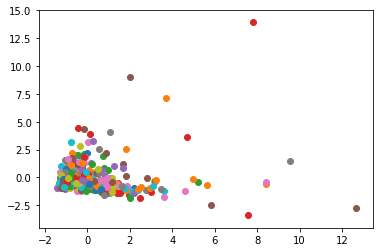

In [52]:
for k, (i,j) in enumerate(zip(X_r[:, 0], X_r[:, 1])):
    plt.scatter(i, j)
    
plt.show()

In [60]:
# km = KMeans(n_clusters=4)
km = KMeans(n_clusters=2)
km.fit(X_r)
print(km.cluster_centers_)

[[-0.39846357  0.03581718]
 [ 3.87773082 -0.3485623 ]]


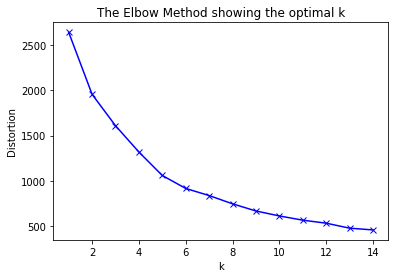

In [61]:

sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    sum_of_squared_distances.append(km.inertia_)
    

    # Plot the elbow
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()